In [335]:
import pandas as pd
import math
import numpy as np
pd.options.display.max_columns = 100


def calculateDistance(x1, y1, x2, y2):
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist


def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)


def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


def add_play_physics(play):
    # Format columns
    play['time'] = pd.to_datetime(play['time'])
    # Distance
    play['dis_meters'] = play['dis'] / 1.0936  # Add distance in meters
    # Speed
    play['dis_meters'] / 0.01
    play['v_mps'] = play['dis_meters'] / 0.1
    # Angles to radians
    play['dir_radians'] = play['dir'].apply(math.radians)
    play['o_radians'] = play['o'].apply(math.radians)
    average_weight_nfl_pounds = 245.86
    average_weight_nfl_kg = average_weight_nfl_pounds * 0.45359237
    # http://webpages.uidaho.edu/~renaes/251/HON/Student%20PPTs/Avg%20NFL%20ht%20wt.pdf
    play['momentum'] = play['v_mps'] * average_weight_nfl_kg
    play['momentum_x'] = pol2cart(play['momentum'], play['dir_radians'])[0]
    play['momentum_y'] = pol2cart(play['momentum'], play['dir_radians'])[1]
    return play


"""
This code loops through every play and:
    1. For each moment in time of the play, for each player in the play:
        - Finds the closest other player to them.
        - Computes the resulting force of the two in relation to eachother.
            - If the force is higher this indicates a higher danger probability.
"""


def calculate_position_details(moment):
    return


def calculate_3_closest(play):
    play_danger_df = pd.DataFrame()
    for time, d in play.groupby('time'):
        for role1, r1data in d.groupby(['role', 'gsisid']):

            if r1data.shape[0] != 1:
                print('ERROR: Multiple values for role {} at time {} is not 1'.format(role1,
                                                                                      time))
            # Loop through other roles to see the closest other player
            min_dist = 5000003  # Large number greater thank any possible distance
            second_min_dist = 5000002
            third_min_dist = 5000001
            for role2, r2data in d.groupby(['role', 'gsisid']):
                if r2data['gsisid'].values[0] != role1[1]:
                    # Check to make sure r1 only has one value
                    if r2data.shape[0] != 1:
                        print('ERROR: Multiple values for role {} at time {} is not 1'.format(role2,
                                                                                              time))
                    x1 = r1data['x'].values[0]
                    x2 = r2data['x'].values[0]
                    y1 = r1data['y'].values[0]
                    y2 = r2data['y'].values[0]

                    this_distance = calculateDistance(x1, y1, x2, y2)
                    if this_distance < min_dist:
                        min_dist = this_distance
                        closest_data = r2data
                    elif this_distance < second_min_dist:
                        if second_min_dist < third_min_dist:
                            third_min_dist = second_min_dist
                        second_min_dist = this_distance
                        second_data = r2data
                    elif this_distance < third_min_dist:
                        third_min_dist = this_distance
                        third_data = r2data
            df = pd.merge(pd.merge(pd.merge(r1data,
                                            closest_data,
                                            on='time',
                                            suffixes=('', '1')),
                                   second_data,
                                   on='time',
                                   suffixes=('', '2')),
                          third_data,
                          on='time',
                          suffixes=('', '3'))
            df['distance_to_1'] = min_dist
            df['distance_to_2'] = second_min_dist
            df['distance_to_3'] = third_min_dist
            play_danger_df = pd.concat([play_danger_df, df])

    play_danger_df = play_danger_df.reset_index()

    play_danger_df['opp_momentum1'] = np.sqrt(np.square(
        play_danger_df['momentum_x'] - play_danger_df['momentum_x1']) +
        np.square(play_danger_df['momentum_y'] - play_danger_df['momentum_y1']))
    play_danger_df['opp_momentum2'] = np.sqrt(np.square(
        play_danger_df['momentum_x'] - play_danger_df['momentum_x2']) +
        np.square(play_danger_df['momentum_y'] - play_danger_df['momentum_y2']))
    play_danger_df['opp_momentum3'] = np.sqrt(np.square(
        play_danger_df['momentum_x'] - play_danger_df['momentum_x3']) +
        np.square(play_danger_df['momentum_y'] - play_danger_df['momentum_y3']))

    return play_danger_df


year = 2017
gamekey = 574
playid = 134

play = pd.read_csv('../working/playlevel/during_play/{}-{}-{}.csv'.format(year,
                                                                          gamekey,
                                                                          playid))
# Keep only needed columns
play = play[['time', 'gsisid', 'x', 'y', 'o', 'dir', 'dis',
             'role', 'mph', 'generalized_role', 'punting_returning_team']]

play = add_play_physics(play)

play_danger_df = calculate_3_closest(play)

# play_danger_df.to_csv('{}-{}-{}-ClosestPartner.csv'.format(year, gamekey, playid))


In [334]:
play_danger_df.head()

,index,time,gsisid,x,y,o,dir,dis,role,mph,generalized_role,punting_returning_team,dis_meters,v_mps,dir_radians,o_radians,momentum,momentum_x,momentum_y,gsisid1,x1,y1,o1,dir1,dis1,role1,mph1,generalized_role1,punting_returning_team1,dis_meters1,v_mps1,dir_radians1,o_radians1,momentum1,momentum_x1,momentum_y1,gsisid2,x2,y2,o2,dir2,dis2,role2,mph2,generalized_role2,punting_returning_team2,dis_meters2,v_mps2,dir_radians2,o_radians2,momentum2,momentum_x2,momentum_y2,gsisid3,x3,y3,o3,dir3,dis3,role3,mph3,generalized_role3,punting_returning_team3,dis_meters3,v_mps3,dir_radians3,o_radians3,momentum3,momentum_x3,momentum_y3,distance_to_1,distance_to_2,distance_to_3,opp_momentum1,opp_momentum2,opp_momentum3
0,0,2017-11-28 01:32:25.800,32188,47.549999,45.000000,2.670000,159.949997,0.0,GL,0.0,Gunner,Punting_Team,0.0,0.0,2.791654,0.046600,0.0,-0.0,0.0,31151,50.000000,43.520000,214.250000,105.000000,0.0,VR,0.0,Jammer,Returning_Team,0.0,0.0,1.832596,3.739368,0.0,-0.0,0.0,33294,45.950001,27.500000,71.529999,277.119995,0.00,PLW,0.000000,Punting_Wing,Punting_Team,0.000000,0.000000,4.836656,1.248434,0.000000,0.00000,-0.00000,33283,47.430000,26.190001,357.130005,272.359985,0.0,PLT,0.0,Punting_Lineman,Punting_Team,0.0,0.0,4.753578,6.233094,0.0,0.0,-0.0,2.862325,17.572991,18.443570,0.0,0.000000,0.0
1,0,2017-11-28 01:32:25.800,33281,47.209999,8.540000,343.859985,106.110001,0.0,GR,0.0,Gunner,Punting_Team,0.0,0.0,1.851969,6.001489,0.0,-0.0,0.0,33855,49.419998,8.950000,185.839996,21.930000,0.0,VL,0.0,Jammer,Returning_Team,0.0,0.0,0.382751,3.243520,0.0,0.0,0.0,31577,45.570000,19.840000,10.540000,236.149994,0.00,PRW,0.000000,Punting_Wing,Punting_Team,0.000000,0.000000,4.121595,0.183958,0.000000,-0.00000,-0.00000,32573,46.919998,21.240000,5.480000,271.709991,0.0,PRT,0.0,Punting_Lineman,Punting_Team,0.0,0.0,4.742234,0.095644,0.0,0.0,-0.0,2.247709,11.418389,12.225220,0.0,0.000000,0.0
2,0,2017-11-28 01:32:25.800,24417,35.090000,24.790001,13.070000,124.459999,0.0,P,0.0,Punter,Punting_Team,0.0,0.0,2.172237,0.228115,0.0,-0.0,0.0,27539,44.299999,22.200001,14.460000,354.750000,0.0,PPR,0.0,Punter_Protector,Punting_Team,0.0,0.0,6.191556,0.252375,0.0,0.0,-0.0,31577,45.570000,19.840000,10.540000,236.149994,0.00,PRW,0.000000,Punting_Wing,Punting_Team,0.000000,0.000000,4.121595,0.183958,0.000000,-0.00000,-0.00000,32573,46.919998,21.240000,5.480000,271.709991,0.0,PRT,0.0,Punting_Lineman,Punting_Team,0.0,0.0,4.742234,0.095644,0.0,0.0,-0.0,9.567245,11.590207,12.351168,0.0,0.000000,0.0
3,0,2017-11-28 01:32:25.800,31075,49.060001,18.900000,159.639999,276.059998,0.0,PDL1,0.0,Defensive_Lineman,Returning_Team,0.0,0.0,4.818156,2.786244,0.0,0.0,-0.0,33765,49.330002,20.580000,178.089996,270.239990,0.0,PDL2,0.0,Defensive_Lineman,Returning_Team,0.0,0.0,4.716578,3.108257,0.0,0.0,-0.0,32573,46.919998,21.240000,5.480000,271.709991,0.00,PRT,0.000000,Punting_Lineman,Punting_Team,0.000000,0.000000,4.742234,0.095644,0.000000,0.00000,-0.00000,32386,47.259998,22.670000,319.029999,258.190002,0.0,PRG,0.0,Punting_Lineman,Punting_Team,0.0,0.0,4.506266,5.568124,0.0,-0.0,-0.0,1.701558,3.170996,3.461446,0.0,0.000000,0.0
4,0,2017-11-28 01:32:25.800,33765,49.330002,20.580000,178.089996,270.239990,0.0,PDL2,0.0,Defensive_Lineman,Returning_Team,0.0,0.0,4.716578,3.108257,0.0,0.0,-0.0,31075,49.060001,18.900000,159.639999,276.059998,0.0,PDL1,0.0,Defensive_Lineman,Returning_Team,0.0,0.0,4.818156,2.786244,0.0,0.0,-0.0,32201,48.959999,22.360001,162.759995,250.759995,0.06,PDL3,1.227273,Defensive_Lineman,Returning_Team,0.054865,0.548647,4.376588,2.840698,61.185196,-20.16211,-57.76779,32573,46.919998,21.240000,5.480000,271.709991,0.0,PRT,0.0,Punting_Lineman,Punting_Team,0.0,0.0,4.742234,0.095644,0.0,0.0,-0.0,1.701558,1.818050,2.498743,0.0,61.185196,0.0


In [329]:
play_danger_df.loc[play_danger_df['distance_to_1'] < 1].sort_values('opp_momentum1')[['time','role','generalized_role','punting_returning_team',
                                                                                      'role1','generalized_role1','punting_returning_team1',
                                                                                      'distance_to_1','opp_momentum1']]

,time,role,generalized_role,punting_returning_team,role1,generalized_role1,punting_returning_team1,distance_to_1,opp_momentum1
342,2017-11-28 01:32:27.300,PLS,Punting_Longsnapper,Punting_Team,PRG,Punting_Lineman,Punting_Team,0.768439,13.344202
347,2017-11-28 01:32:27.300,PRG,Punting_Lineman,Punting_Team,PLS,Punting_Longsnapper,Punting_Team,0.768439,13.344202
320,2017-11-28 01:32:27.200,PLS,Punting_Longsnapper,Punting_Team,PRG,Punting_Lineman,Punting_Team,0.772009,23.815904
325,2017-11-28 01:32:27.200,PRG,Punting_Lineman,Punting_Team,PLS,Punting_Longsnapper,Punting_Team,0.772009,23.815904
365,2017-11-28 01:32:27.400,PLT,Punting_Lineman,Punting_Team,PDR2,Defensive_Lineman,Returning_Team,0.713094,27.565956
359,2017-11-28 01:32:27.400,PDR2,Defensive_Lineman,Returning_Team,PLT,Punting_Lineman,Punting_Team,0.713094,27.565956
298,2017-11-28 01:32:27.100,PLS,Punting_Longsnapper,Punting_Team,PRG,Punting_Lineman,Punting_Team,0.780064,31.011213
303,2017-11-28 01:32:27.100,PRG,Punting_Lineman,Punting_Team,PLS,Punting_Longsnapper,Punting_Team,0.780064,31.011213
335,2017-11-28 01:32:27.300,PDL3,Defensive_Lineman,Returning_Team,PLS,Punting_Longsnapper,Punting_Team,0.863133,31.170857
386,2017-11-28 01:32:27.500,PLS,Punting_Longsnapper,Punting_Team,PDL3,Defensive_Lineman,Returning_Team,0.836001,31.519266


# Try on a known injury play

In [336]:
year = 2017
gamekey = 553
playid = 1683

play = pd.read_csv('../working/playlevel/during_play/{}-{}-{}.csv'.format(year,
                                                                          gamekey,
                                                                          playid))
# Keep only needed columns
play = play[['time', 'gsisid', 'x', 'y', 'o', 'dir', 'dis',
             'role', 'mph', 'generalized_role', 'punting_returning_team']]

play = add_play_physics(play)

play_danger_df2 = calculate_3_closest(play)

In [379]:
play_danger_df2.loc[(play_danger_df2['distance_to_1'] < 1)].sort_values('opp_momentum1')[['time','role','generalized_role','punting_returning_team',
                                                                                      'role1','generalized_role1','punting_returning_team1',
                                                                                      'distance_to_1','opp_momentum1','dir','o','o1','dir1']].tail()

,time,role,generalized_role,punting_returning_team,role1,generalized_role1,punting_returning_team1,distance_to_1,opp_momentum1,dir,o,o1,dir1
2171,2017-11-19 19:16:21.600,PDL2,Defensive_Lineman,Returning_Team,PLS,Punting_Longsnapper,Punting_Team,0.800813,649.137828,265.100006,158.160004,320.299988,22.129999
2017,2017-11-19 19:16:20.900,PDL2,Defensive_Lineman,Returning_Team,VLo,Jammer,Returning_Team,0.912360,802.176769,269.959991,164.309998,26.420000,31.100000
2249,2017-11-19 19:16:21.900,PRW,Punting_Wing,Punting_Team,PR,Punt_Returner,Returning_Team,0.493963,989.598936,298.290009,204.679993,335.570007,47.419998
2246,2017-11-19 19:16:21.900,PR,Punt_Returner,Returning_Team,PRW,Punting_Wing,Punting_Team,0.493963,989.598936,47.419998,335.570007,204.679993,298.290009
2225,2017-11-19 19:16:21.800,PR,Punt_Returner,Returning_Team,PRW,Punting_Wing,Punting_Team,0.783902,1050.279236,44.520000,331.950012,208.380005,297.380005


In [353]:
import sys
sys.path.insert(0,'../scripts/')

from football_field import create_football_field

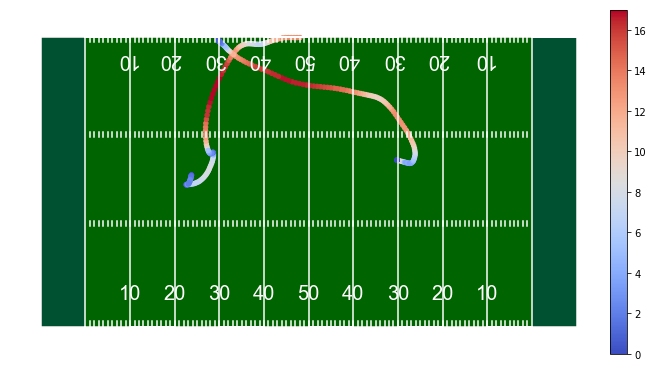

In [376]:
fig, ax = create_football_field()
play.loc[play['role'].isin(['PR','PRW'])][['x','y']].plot('x', 'y', kind='scatter', ax=ax, c=play.loc[play['role'].isin(['PR','PRW'])]['mph'].tolist(), cmap='coolwarm')

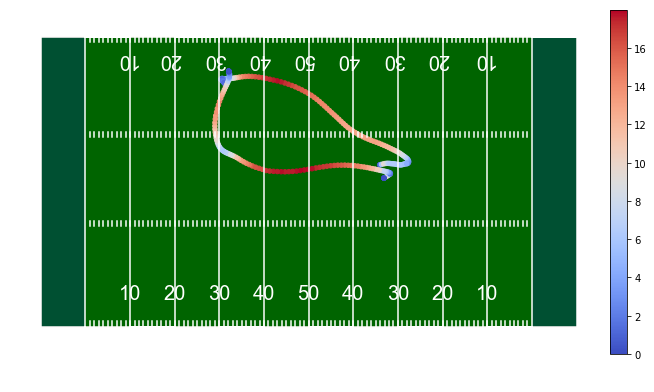

In [377]:
fig, ax = create_football_field()
play.loc[play['role'].isin(['PLS','PDL2'])][['x','y']].plot('x', 'y', kind='scatter', ax=ax, c=play.loc[play['role'].isin(['PLS','PDL2'])]['mph'].tolist(), cmap='coolwarm')

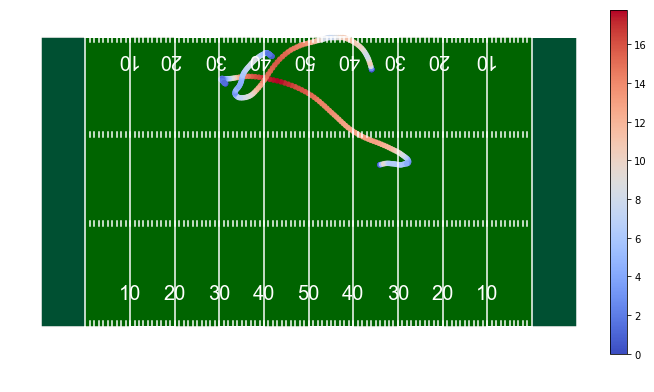

In [380]:
fig, ax = create_football_field()
play.loc[play['role'].isin(['PDL2','VLo'])][['x','y']].plot('x', 'y', kind='scatter', ax=ax, c=play.loc[play['role'].isin(['PDL2','VLo'])]['mph'].tolist(), cmap='coolwarm')